# Importing Packages

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset

import albumentations as aug

import torchvision
from torchvision import transforms, models, datasets
from torchsummary import summary

import numpy as np
import pandas as pd
import os, glob, cv2

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn import cluster
from copy import deepcopy
import glob

%matplotlib inline
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Downloading and importing data

In [ ]:
!git clone https://github.com/udacity/P1_Facial_Keypoints.git

Cloning into 'P1_Facial_Keypoints'...
remote: Enumerating objects: 5984, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 5984 (delta 0), reused 0 (delta 0), pack-reused 5981
Receiving objects: 100% (5984/5984), 329.50 MiB | 40.01 MiB/s, done.
Resolving deltas: 100% (121/121), done.
Checking out files: 100% (5803/5803), done.


In [ ]:
os.listdir()

['.config', 'P1_Facial_Keypoints', 'sample_data']

In [ ]:
root_dir = './P1_Facial_Keypoints/data/training/'

In [ ]:
all_img_paths = glob.glob(os.path.join(root_dir, '*.jpg'))

In [ ]:
data = pd.read_csv('./P1_Facial_Keypoints/data/training_frames_keypoints.csv')
data.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,125.0,62.0,130.0,66.0,134.0,73.0,136.0,81.0,139.0,92.0,134.0,96.0,130.0,98.0,126.0,102.0,120.0,102.0,111.0,104.0,105.0,104.0,99.0,102.0,90.0,51.0,89.0,56.0,87.0,60.0,...,68.0,119.0,73.0,117.0,77.0,115.0,79.0,117.0,81.0,115.0,85.0,117.0,90.0,117.0,87.0,122.0,85.0,124.0,81.0,124.0,77.0,124.0,73.0,121.0,70.0,119.0,77.0,119.0,79.0,119.0,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,119.0,58.0,130.0,64.0,136.0,73.0,141.0,85.0,143.0,96.0,137.0,102.0,131.0,107.0,124.0,109.0,114.0,111.0,105.0,111.0,97.0,111.0,88.0,111.0,78.0,51.0,83.0,56.0,81.0,62.0,...,70.0,122.0,75.0,122.0,81.0,120.0,83.0,120.0,85.0,120.0,90.0,120.0,94.0,120.0,90.0,124.0,87.0,126.0,83.0,126.0,79.0,126.0,75.0,124.0,70.0,122.0,79.0,122.0,83.0,122.0,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,103.0,60.0,111.0,62.0,116.0,67.0,122.0,75.0,127.0,86.0,127.0,96.0,123.0,105.0,121.0,113.0,114.0,118.0,106.0,122.0,100.0,124.0,91.0,128.0,81.0,58.0,56.0,62.0,54.0,67.0,...,67.0,103.0,69.0,101.0,73.0,101.0,75.0,101.0,77.0,101.0,84.0,103.0,88.0,108.0,82.0,110.0,77.0,110.0,75.0,110.0,71.0,110.0,69.0,107.0,67.0,103.0,73.0,103.0,75.0,105.0,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,132.0,61.0,141.0,64.0,148.0,73.0,157.0,85.0,163.0,101.0,163.0,116.0,164.0,128.0,161.0,137.0,155.0,144.0,143.0,150.0,134.0,156.0,121.0,162.0,109.0,70.0,68.0,76.0,65.0,85.0,...,76.0,129.0,82.0,130.0,88.0,127.0,91.0,130.0,98.0,130.0,104.0,133.0,110.0,139.0,101.0,142.0,95.0,145.0,88.0,142.0,82.0,142.0,79.0,139.0,76.0,129.0,85.0,133.0,91.0,133.0,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,130.0,71.0,136.0,75.0,138.0,81.0,141.0,92.0,143.0,105.0,139.0,113.0,135.0,122.0,129.0,126.0,122.0,128.0,112.0,130.0,103.0,130.0,95.0,130.0,86.0,58.0,81.0,60.0,74.0,64.0,...,75.0,121.0,79.0,117.0,84.0,115.0,86.0,115.0,90.0,113.0,96.0,115.0,103.0,118.0,98.0,122.0,92.0,124.0,88.0,124.0,84.0,126.0,79.0,124.0,77.0,121.0,84.0,117.0,88.0,117.0,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


# Defining the dataset class

In [ ]:
class FacesData(Dataset):

  def __init__(self, df, root_dir):
    super(FacesData, self).__init__()
    self.df = df
    self.root_dir = root_dir
    self.normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                          std = [0.229, 0.224, 0.225])
    
  def __len__(self):
    return len(self.df)

  def __getitem__(self, item):
    img_path = self.root_dir + '/' + self.df.iloc[item, 0]
    img = cv2.imread(img_path)/255.
    kp = deepcopy(self.df.iloc[item, 1:].tolist())
    kp_x = (np.array(kp[0::2])/img.shape[1]).tolist()
    kp_y = (np.array(kp[1::2])/img.shape[0]).tolist()

    kp2 = kp_x + kp_y
    kp2 = torch.tensor(kp2)
    img = self.preprocess_input(img)

    return img, kp2

  def preprocess_input(self, img):
    img = cv2.resize(img, (224,224))
    img = torch.tensor(img).permute(2,0,1)
    img = self.normalize(img).float()
    return img.to(device)

  def load_img(self, item):
    img_path = self.root_dir + '/' + self.df.iloc[item, 0]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    return img

# Making the DataLoader

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=101)

train_dataset = FacesData(train.reset_index(drop = True), root_dir)
test_dataset = FacesData(test.reset_index(drop = True), root_dir) 

train_loader = DataLoader(train_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Creating the model

In [ ]:
summary(models.vgg16(pretrained=True).to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
def get_model():
  model = models.vgg16(pretrained=True)

  for param in model.parameters():
    param.requires_grad = False

  model.avgpool = nn.Sequential(
      nn.Conv2d(512, 512, 3),
      nn.MaxPool2d(2),
      nn.Flatten()
  )

  model.classifier = nn.Sequential(
      nn.Linear(2048, 512),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(512, 136),
      nn.Sigmoid()
  )

  criterion = nn.L1Loss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

  return model.to(device), criterion, optimizer

In [ ]:
model, criterion, optimizer = get_model()

In [ ]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

# Creating the training functions

In [ ]:
def train_batch(img, kps, model, optimizer, criterion):
  model.train()
  optimizer.zero_grad()
  pred_kps = model(img.to(device))
  loss = criterion(pred_kps, kps.to(device))
  loss.backward()
  optimizer.step()
  return loss

In [ ]:
def validate_batch(img, kps, model, criterion):
  model.eval()
  with torch.no_grad():
    pred_kps = model(img.to(device))
    loss = criterion(pred_kps, kps.to(device))
    return pred_kps, loss

In [ ]:
def train_loop(n_epochs=50):

  train_loss = []
  val_loss = []

  for epoch in range(n_epochs):

    epoch_train_loss = 0
    epoch_val_loss = 0

    for ix, (img, kps) in enumerate(train_loader):
      loss = train_batch(img, kps, model, optimizer, criterion)
      epoch_train_loss += loss.item()

    epoch_train_loss /= (ix + 1)
    
    for ix, (img, kps) in enumerate(test_loader):
      ps, loss = validate_batch(img, kps, model, criterion)
      epoch_val_loss += loss.item()

    epoch_val_loss /= (ix+1)

    print(f'epoch: {epoch+1}, train_loss: {epoch_train_loss}, val_loss: {epoch_val_loss}')

    train_loss.append(epoch_train_loss)
    val_loss.append(epoch_val_loss)

  return train_loss, val_loss

# Training the model

In [ ]:
history = train_loop()

epoch: 1, train_loss: 0.05805791207942469, val_loss: 0.03434755280613899
epoch: 2, train_loss: 0.041087467951336124, val_loss: 0.02702888541600921
epoch: 3, train_loss: 0.034470490361938534, val_loss: 0.025344502011483364
epoch: 4, train_loss: 0.031527598056642486, val_loss: 0.027707819911566647
epoch: 5, train_loss: 0.029375946641653435, val_loss: 0.024266745895147324
epoch: 6, train_loss: 0.027619189465011674, val_loss: 0.022485939277843994
epoch: 7, train_loss: 0.026217578728308624, val_loss: 0.021808408031409435
epoch: 8, train_loss: 0.024621187484469908, val_loss: 0.022148935801603577
epoch: 9, train_loss: 0.024071610350718444, val_loss: 0.02218041983856396
epoch: 10, train_loss: 0.023650492980391128, val_loss: 0.026101770726117222
epoch: 11, train_loss: 0.02357295343930694, val_loss: 0.02269961363212629
epoch: 12, train_loss: 0.02225081179419468, val_loss: 0.020517990839752285
epoch: 13, train_loss: 0.021271228940151203, val_loss: 0.020046647638082504
epoch: 14, train_loss: 0.020

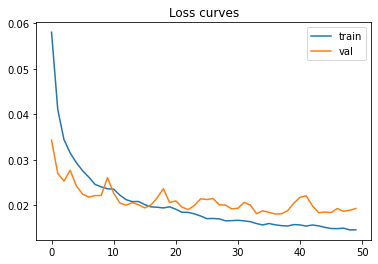

In [ ]:
plt.plot(range(len(history[0])), history[0], label='train')
plt.plot(range(len(history[1])), history[1], label='val')
plt.title('Loss curves')
plt.legend()

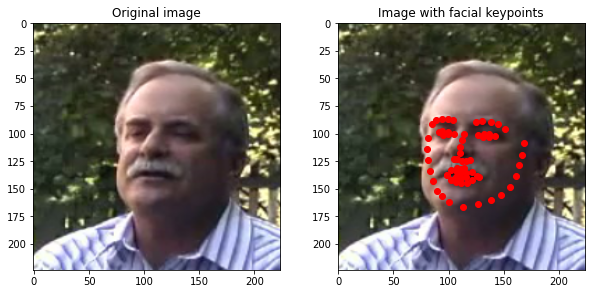

In [ ]:
ix = 3
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('Original image')
im = test_dataset.load_img(ix)
plt.imshow(im)
plt.grid(False)
plt.subplot(222)
plt.title('Image with facial keypoints')
x, _ = test_dataset[ix]
plt.imshow(im)
kp = model(x[None]).flatten().detach().cpu()
plt.scatter(kp[:68]*224, kp[68:]*224, c='r')
plt.grid(False)
plt.show()

In [ ]:
torch.save(model.state_dict(), '/content/model.bin')